# Ergodic Information Harvesting Tutorial
In this tutorial, a minimal working example is given to build intuition of each component of the ergodic information harvesting algorithm.

Chen Chen & Malcolm MacIver

April 2018

## Table of Contents
1. [Example Description](#0.-Example-Description)
2. [Measurement Model](#1.-Measurement-Model)
3. [Likelihood](#3.-Likelihood)
4. [Bayesian Filter](#4.-Bayesian-Filter)
5. [Expected Entropy Reduction](#5.-Expected-Entropy-Reduction)

***

## 1. Example Description
To start our tutorial, let's define a scenario. Imagine we have a robot equipped with a microphone capable of moving along a line. There is a stationary buzzer that generates a fixed-intensity sound located in the same space. The microphone on the robot only gives the loudness of the sound it picks up---ignoring pitch. The task here is to move the robot along the 1D axis to take measurements and use them to estimate the location of the buzzer.

## 2. Observation Model

For the sake of simplicity, let's say our robot can only move within between 0 to 1. We can represent the scenario as:

- A sensor (microphone), with location denoted by $x$, can move freely within 1D space $x \in \mathbb{X}=[0, 1]$
- A signal source (buzzer) is fixed at a particular location within the 1D space $\theta \in [0, 1]$
- The sensor's measurement of sound loudness is denoted by $V \in \mathbb{V} = [0, 1]$

An observation model serves as a proxy to help relate measured variables to latent variables. Given the definition above, the observation model, in our case, helps relate the measured **loudness of sound** to the **location of the sound source (buzzer)**. For example, receiving a numerical measurement of $V=0.5$ does not give us any information about where the sound source is *unless we have a observation model of our sensor*. 

In [1]:
# Import need libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.pyplot import plot
from scipy.stats import norm, entropy, recipinvgauss
from scipy.interpolate import interp1d
from scipy.signal import convolve

# Configure Matplotlib
%matplotlib inline

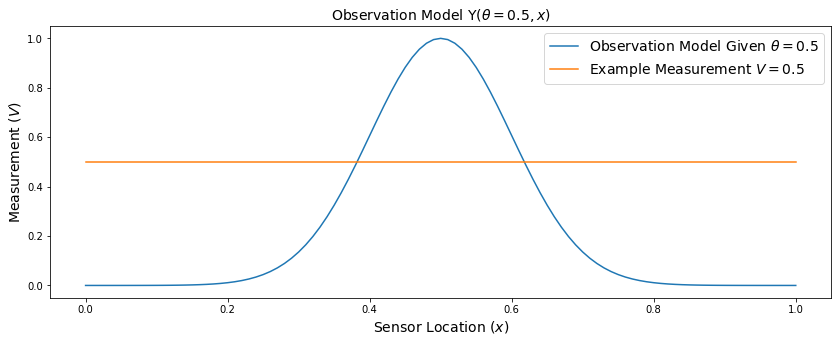

In [2]:
# Working space
wsResolution = 101 # Working space spatial resolution
wsSamples = np.linspace(0, 1, wsResolution)

# Finally, construct a function version of the observation model for the use of next section
def Upsilon(theta=0.5, sigmaM=0.1):
    if type(theta) is float:
        mm = norm.pdf(wsSamples,theta,sigmaM)
        mm /= max(mm)
    else:
        # query multiple possible target theta
        mm = []
        for t in theta:
            mm_ = norm.pdf(wsSamples,t,sigmaM)
            mm_ /= max(mm_)
            mm.append(mm_)
        mm = np.array(mm)
    return mm
  
# Visualize the measurement model
plt.figure(figsize=(14,5));
plot(wsSamples, Upsilon(0.5));
plot(wsSamples, np.tile([0.5], wsResolution))
plt.legend((r'Observation Model Given $\theta = 0.5$', 'Example Measurement $V = 0.5$'), fontsize=14, loc='best')
plt.xlabel('Sensor Location ($x$)', fontsize=14);
plt.ylabel('Measurement ($V$)', fontsize=14);
plt.title(r"Observation Model $\Upsilon(\theta = 0.5, x)$", fontsize=14);

The plot above shows what a generic observation model looks like. Specifically, this is a generic symmetric Gaussian observation model as it was generated with a Gaussian kernel in a symmetric workspace. For our microphone and buzzer example, the buzzer location is fixed at $\theta=0.5$, and the Gaussian curve represents the signal picked up by the microphone as we move the sensor $x$ smoothly from 0 to 1. Plotting all of the sensor measurements on the Y axis and sensor's location on the X axis generates the observation model visualization shown above. 

As the sensor moves closer to the buzzer's location at 0.5, we get a larger sensor reading, and the opposite happens as we move away from 0.5. Clearly, given a measurement of $V = 0.5$, the expected location of the source can be inferred by referring to the measurement model. Drawing a green line of $V=0.5$ in the same plot, we can find two possible solutions (where the green line crosses with the blue curve) due to the symmetric property of our observation model.

## 3. Likelihood

Thus far the observation model itself has no uncertainty: if you receive a measurement $V=0.5$ as shown above, you might be in one of two locations, but whichever the two it is, you are at exactly the location given by the intersection of the green and blue curves. In other words, the resulting solutions of $x$ that satistifies $\Upsilon(\theta = 0.5, x)=0.5$ is deterministic, though not unique. Other than toy world cases like this, there is of course always uncertainty. One of the most common forms of uncertainty is measurement noise. Somewhere in the measurement process, either in the sensor itself or in the analog-to-digital converter we are using or something else (for example, a limited number of significant digits in the floating point numbers of the computer representing our measurements), noise will occur. Therefore, instead of getting measurements that match exactly with the observation model, additive noise is also present. Perhaps the simplest way to incorporate this is with addition of zero-mean Gaussian noise, as follows:
$$
V = \Upsilon(\theta, x) + \epsilon
$$
where $\Upsilon(\theta, x)$ is the observation model and $\epsilon$ represents the additive zero-mean Gaussian noise.

How should this uncertainty be represented in the process of inferring the latent variable (*i.e.* the location of the target $\theta$) using the measurement model? One method is to use a Gaussian likelihood function.

### Intuituion of Likelihood Function
The likelihood function does essentially the same operation as our example in the measurement plot of drawing a measurement line on top of the measurement model to figure out where the target location is. The main difference is that the aformentioned approach assumes no uncertainty baecause we used only one solid line to represent a measurement. Given uncertainty, our measurement could be in the form of $V=0.5\pm0.1$, where 0.5 is from the observation model and 0.1 represents the uncertainty from the additive zero-mean Gaussian noise. This is equavalent to drawing a series of lines within $0.5\pm0.1$ and using that to estimate a range of possible target locations. The likelihood function takes care of this transition formally by telling us how likely it is that the target $\theta$ is located in a particular location given a measurement $V$.

Now that we have defined a observation model $\Upsilon(\theta = 0.5, x)$ (assuming target is fixed at $\theta = 0.5$ for convenience), we can compute the likelihood function for a sensor to receive a given measurement $V$, for instance, $V=0.5$ given target location $\theta=0.5$ for all the possible sensor locations $x$ by simply applying the equation for a Gaussian distribution for each location:
$$
p(V~\rvert~\theta=0.5, x) = \frac{1}{\sqrt{2\pi}\sigma} \exp{[-\frac{(V-\Upsilon(\theta=0.5,x))^2}{2\sigma^2}]}
$$

For example:

The probability of sensor getting a reading 0.5 at position 0.0 given target location 0.5 is
	p(V = 0.5 | theta = 0.5, x = 0.0) = 0.0020


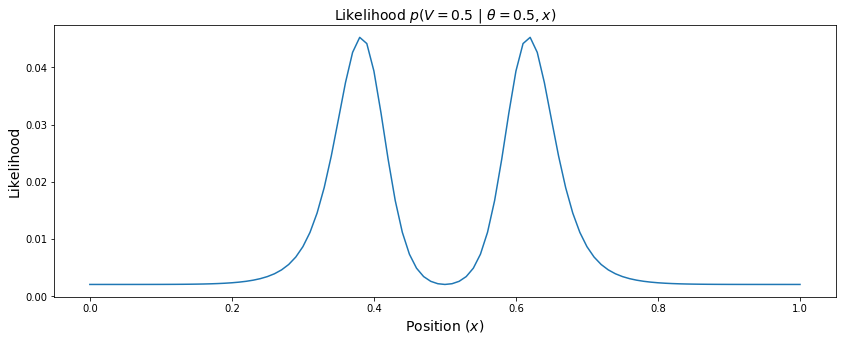

In [3]:
# Compute likelihood distribution
def Pvtheta(v, theta, sigmaM=0.1, sigmaL=0.2):
  # Compute likelihood
  pvt = ( 1.0 / (np.sqrt(2.0*np.pi) * sigmaL) ) * np.exp( -(v - Upsilon(theta, sigmaM))**2 / (2.0 * sigmaL**2) )
  # Normalize
  if pvt.ndim == 1:
    return pvt / pvt.sum()
  else:
    for idx in range(pvt.shape[0]):
      pvt[idx, :] /= pvt[idx, :].sum()
  return pvt

# Visualize likelihood distribution
plt.figure(figsize=(14,5))
plot(wsSamples, Pvtheta(0.5, 0.5))
plt.xlabel('Position ($x$)', fontsize=14)
plt.ylabel(r'Likelihood', fontsize=14)
plt.title(r'Likelihood $p(V=0.5~|~\theta=0.5, x)$', fontsize=14)

# Which gives a map of the probability of sensor getting measurement of 0.5 given target location 0.5
print("For example:\n\nThe probability of sensor getting a reading 0.5 "
      "at position 0.0 given target location 0.5 is\n"
      f"\tp(V = 0.5 | theta = 0.5, x = 0.0) = {Pvtheta(0.5, 0.5)[0]:.4f}")

The above function shows the likelihood function based on a specific measurement. In this case, we know we have received a measurement $V=0.5$ and now we are trying to figure out where the buzzer is ($\theta$). Since we have a observation model already, simply plug the measurement $V = 0.5$ into the observation model to query for the relative distance $x$ should answer this question. However, the measurement we received from the sensor is not perfect in reality and is always contaminated by noise or other forms of uncertainty. Therefore, the sensor receiving a measurement $V = 0.5$ should represent a range of possible buzzer locations with different probability instead of just 1 location with 100% certainty to ensure robustness. That's the core concept of constructing the likelihood function.

Given the location of the target (*i.e.* buzzer, $\theta=0.5$) as well as a measurement $V = 0.5$, the likelihood shown above is a function of position $x$ in the X axis and likelihood of the sensor receiving measurement $V = 0.5$ at this particular location on the Y axis given $\theta = 0.5$. Together, it gives us information of how likely it is that the buzzer is at a particular location $x$ for all the candidate $x \in \mathcal{X}$.

## 4. Bayesian Filter

### Probability Distribution, Probability Density Function (Belief), and Entropy of the Belief
The goal of the example is to take consecutive measurements through the microphone to form an accurate estimate of the buzzer's location. Our robot's knowledge about the buzzer's location can be captured in a probability distribution. We can visualize this in the form of a probability density function (PDF) $P(\theta)$ where $\theta$ is the buzzer's location we are trying to estimate. The PDF is often referred as the belief as it represents how much the robot believes the buzzer is located for all of the possible candidate positions. Let's use an example to demonstrate what the belief PDF looks like and how it can be applied to help us achieve our goal.

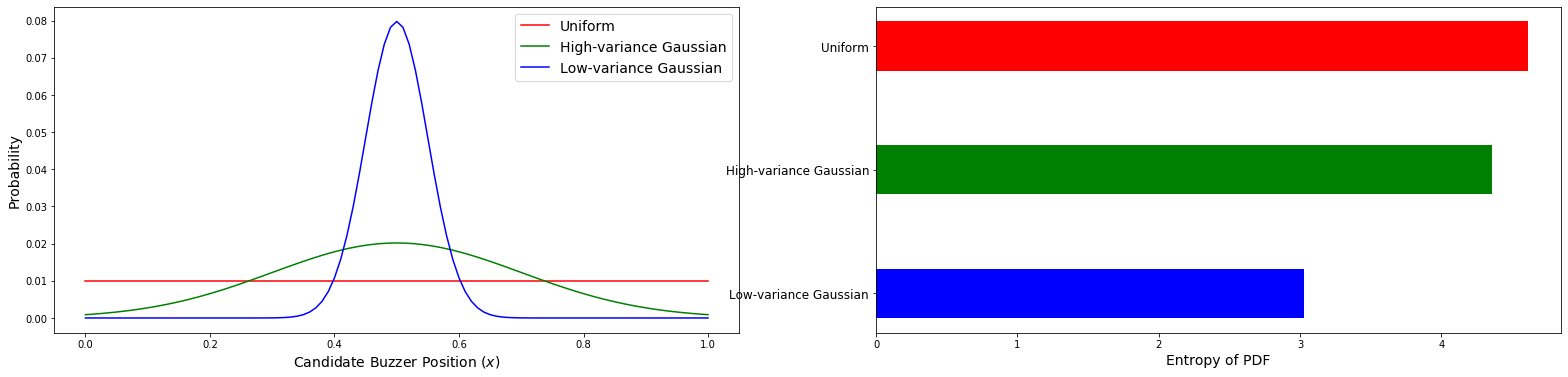

In [4]:
# Plot some PDF as example and their corresponding entropy
priorP1 = np.ones(wsResolution)/wsResolution # An uniform "uninformative" PDF
priorP3 = norm.pdf(wsSamples,0.5,0.2)        # A high-variance Gaussian PDF
priorP4 = norm.pdf(wsSamples,0.5,0.05)       # A low-variance Gaussian PDF
priorP1 /= priorP1.sum()
priorP3 /= priorP3.sum()
priorP4 /= priorP4.sum()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(27,6))
ax1.plot(wsSamples, priorP1, color='r')
ax1.plot(wsSamples, priorP3, color='g')
ax1.plot(wsSamples, priorP4, color='b')
ax1.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax1.set_ylabel(r'Probability', fontsize=14)
ax1.legend(('Uniform', 'High-variance Gaussian', 'Low-variance Gaussian'), 
           fontsize=14, loc='best');

ax2.barh([0,1,2], [entropy(priorP1), entropy(priorP3), entropy(priorP4)], height=0.4, 
        color=['r', 'g', 'b'])
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(('Uniform', 'High-variance Gaussian', 'Low-variance Gaussian'), 
                   fontsize=12)
ax2.invert_yaxis()
ax2.set_xlabel(r'Entropy of PDF', fontsize=14);

The plot above shows three different belief PDFs. In our case, a belief is a function of candidate buzzer position in X and probability in Y axis. We can easily encode our knowledge of the buzzer's location through the belief. Each one of the three types of belief shown above represents a unique scenario:
- **Uniform** - The probability of every candidate buzzer position matches the real buzzer location is equal. This is essentially means that our robot knows nothing about the buzzer's location.
- **High-variance Gaussian** - Our robot has a rough clue that the buzzer should be near location 0.5 because that's where the peak of the belief is, but the high variance of the PDF means we are not so sure about our guess.
- **Low-variance Gaussian** - Our robot has a fairly clear idea that the buzzer is around 0.5. This time we can make a better guess since our belief is less spread out.

Clearly, as we go from a uniform to low-variance Gaussian belief PDF, the robot gradually knows more about where the buzzer is. This gradual improvement can be quantified by measuring the entropy of the belief shown on the right panel. The entropy is highest with the uniform belief and gradually lowers as the variance lowers in the Gaussian case. The entropy of the belief provides a way for us to compare different beliefs in order to determine how good our current estimate is. Recall that the goal is for our robot to successfully estimate the location of the buzzer. However, it's unclear what exactly to do with this goal since we never defined what success means. Now, with the belief and entropy of belief defined, we can define a rigorous criteria by saying that the robot succeeds in locating the buzzer if the entropy of its current belief is below a certain threshold, which can be represented as
$$
S\left[p(\theta)\right] = -\int_\theta p(\theta) \log p(\theta) \leqslant \delta
$$
where $p(\theta)$ is the belief and $\delta$ is a small number.

### Recursive Bayesian Filtering
At this point, we have already defined:
- **The Observation Model $\Upsilon(\theta, x)$**, which captures the intrinsic property of the sensor we have and can be used to relate the measured quantity, in our example the loudness of sound, to the latent variable, in our example the location of the buzzer.
- **The Likelihood Function $p(V~\rvert~\theta, x)$**, which quantifies where the target is likely to be given a specific measurement received.
- **The Belief $p(\theta)$**, which encodes all the information we know about the target's location in the form of a probability density map.

Let's say we begin with a uniform belief and let the robot take a measurement at its current location $x_0$. Intuitively, any new measurement we get will contain some new information about where the target is and should help us improve the belief. However, the three components we have above are not enough to let us update our belief with any new measurement. Given a measurement $V$, we can use the observation model to evaluate the likelihood function. The question is how do we use the likelihood function to update our belief so that the new information can be encoded---that's where the Bayesian filter kicks in.

$$
p(\theta~\rvert~V, x) = \dfrac{p(V~\rvert~\theta, x)~p(\theta)}{p(V)} = \eta~p(V~\rvert~\theta, x)~p(\theta)
$$

where, $p(V~\rvert~\theta, x)$ is the likelihood, $p(\theta)$ is the prior belief (belief before update), and $p(\theta~\rvert~V, x)$ is the posterior belief (belief after update). Note that $p(V)$ is a constant that is independent of both $\theta$ and $x$, therefore it can be safely replaced by a normalization factor $\eta$ to make sure $p(\theta~\rvert~V, x)$ is still a probability density function. The equation shows how to update the belief using Bayesian inference. The recursive Bayesian filter take the same form but is done recursively. For every new measurement $V_t$ at time $t$, the Bayesian filter recursively updates the prior belief $p(\theta~\rvert~V_{t-1}, x)$ with the equation above.

## 5. Expected Information Density
At this point we know how to use sensor measurements to recursively update the belief. But, do all sensor measurements have the same effect on our belief when used in the Bayesian filter? In other words, are all measurements equally informative? To answer this question, imagine two different scenarios where the robot take measurements at location 0 and 0.5, denoted by $V_1$ and $V_2$, respectively. According to the previously defined observation model, we have $V_1\approx0$ and $V_2\approx1$. This translates into $V_1$ telling us that "the target is probably not here" and $V_2$ telling us that "the target should be very close". Which measurement do you think yields more information about the location of the target, in other words, better posterior belief with lower entropy?

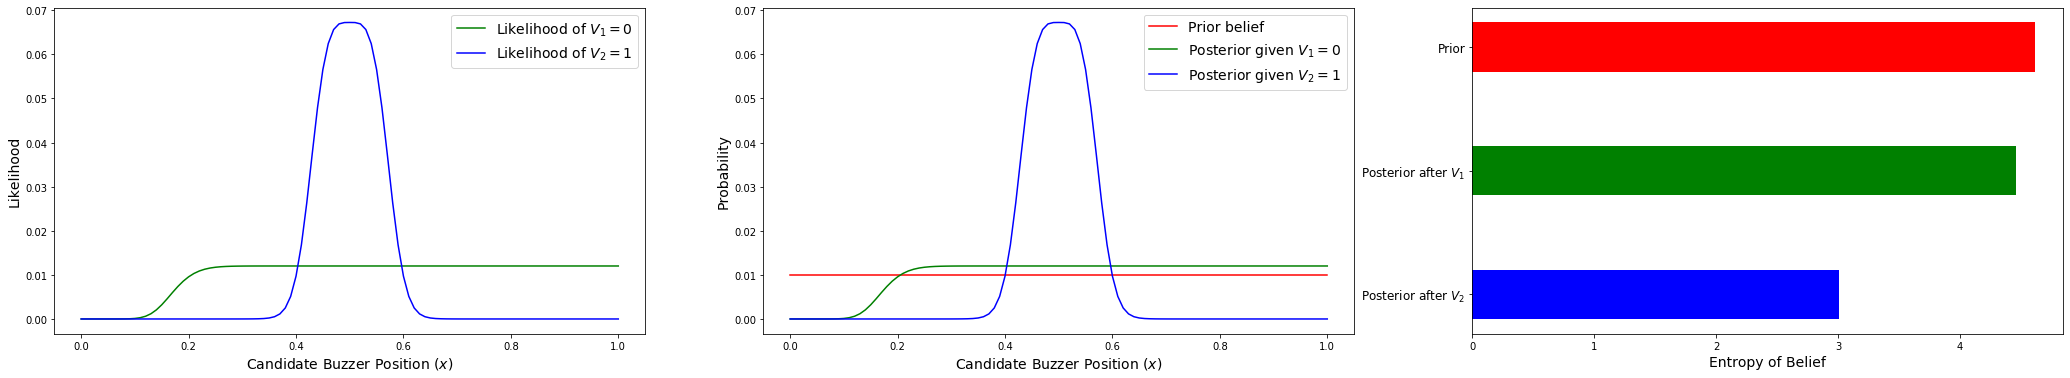

In [5]:
# Plot some PDF as example and their corresponding entropy
priorP1 = np.ones(wsResolution)/wsResolution # An uniform "uninformative" PDF
priorP1 /= priorP1.sum()

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36,6))
ax1.plot(wsSamples, Pvtheta(0, 0.0), color='g', label='Likelihood of $V_1=0$')
ax1.plot(wsSamples, Pvtheta(1, 0.5), color='b', label='Likelihood of $V_2=1$')
ax1.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax1.set_ylabel(r'Likelihood', fontsize=14)
ax1.legend(fontsize=14, loc='best');

ppP1 = priorP1 * Pvtheta(0, 0.0)
ppP2 = priorP1 * Pvtheta(1, 0.5)
ppP1 /= ppP1.sum()
ppP2 /= ppP2.sum()

ax2.plot(wsSamples, priorP1, color='r', label='Prior belief')
ax2.plot(wsSamples, ppP1, color='g', label='Posterior given $V_1=0$')
ax2.plot(wsSamples, ppP2, color='b', label='Posterior given $V_2=1$')
ax2.set_xlabel(r'Candidate Buzzer Position ($x$)', fontsize=14)
ax2.set_ylabel(r'Probability', fontsize=14)
ax2.legend(fontsize=14, loc='best');

ax3.barh([0,1,2], [entropy(priorP1), entropy(ppP1), entropy(ppP2)], height=0.4, 
        color=['r', 'g', 'b'])
ax3.set_yticks([0, 1, 2])
ax3.set_yticklabels(('Prior', 'Posterior after $V_1$', 'Posterior after $V_2$'), 
                   fontsize=12)
ax3.invert_yaxis()
ax3.set_xlabel(r'Entropy of Belief', fontsize=14);

Clearly, $V_2$ wins. The entropy of the posterior belief after getting measurement $V_2$ leads to a much lower entropy when compared to $V_1$. This example tells us two main messages:
1. Not all measurements are equally informative. Some measurements are more informative than others because they rule out more of the potential locations of the target.
2. Entropy of the belief can be used to evaluate how informative a measurement is, with lower entropy being more informative than higher.

It definitely sounds silly to let the robot radomly sample the entire workspace to take measurement. It also does not sound right for the robot to take a measurement at a fixed location no matter what. Given the current belief, is there any good strategy that can help the sensor predict which location could lead to more informative measurement? The answer is yes and it involves the use the expected entropy reduction to form an expected information density (EID) map. 

### Computing Expected Information Density
As shown in the example above, information density can be quantified as entropy reduction which correlates with better estimation. If will be very helpful if we can compute an EID map using expected entropy reduction, which is going to be in the form of expected reduction in the entropy of a new posterior should the sensor take a measurement at a given position. We have already demonstrated the core concept of EID map: for every given location $x$ in the workspace, given the probability of $\theta$ being a particular value, and given the likelihood of receiving a particular voltage $V$ corresponding to that value, what is the average amount of information we expect to receive by visiting location $x$? Let's try to break this down step-by-step:

1. Define observation model $\Upsilon(\theta,x))$ and Gaussian likelihood function 
    $$
    p(V~\rvert~\theta, x) = \frac{1}{\sqrt{2\pi}\sigma} \exp{\left[-\frac{(V-\Upsilon(\theta,x))^2}{2\sigma^2}\right]}
    $$
    which predicts how likely the sensor will obtain a measurement $V \in \mathcal{V}$ given the current belief $p(\theta)$, where $\mathcal{V}$ is the set of all possible sensor measurements. Here $x \in \mathcal{X}$ is the location of the sensor ($\mathcal{X}$ is the space of all possible sensor locations), and $\Upsilon(\theta,x)$ is the observation model assuming a known target location $\theta$ evaluated at sensor location $x$.

2. With a predicted distribution of measurements for each choice of $x$ from the likelihood function $p(V~\rvert~\theta,x)$, we then evaluate what the expected new posterior belief $p(\theta~\rvert~V,x)$ is if the sensor were to take a hypothetical measurement at a given location $x$ in the workspace. For each choice of potential $x$ where a sensor measurement could be taken, the new posterior is computed by applying the Bayesian update rule
	$$
	p(\theta~\rvert~V, x) = \eta_1 p(\theta)~p(V~\rvert~\theta, x)
	$$
	where $\eta_1$ is a normalization factor.
    
3. Evaluate the overall expected new belief $p(\theta, x)$ by computing the average $p(\theta~\rvert~V, x)$, weighted by $p(\theta)$ (also called marginalization), over all the possible measurement values $V$ 
	that the sensor might get at location $x$, we can obtain the expectation of the  new belief 
	$p(\theta, x)$---the statistical mean update to the belief based on taking a measurement at $x$:
	$$
	p(\theta, x) = \eta_2 \int_V p(\theta)~p(V~\rvert~\theta, x) dV
	$$
	where $\eta_2$ is a normalization factor.

4. Finally, with a prediction of what the new belief would be if a measurement were to be taken at $x$, we predict the expected entropy reduction by computing the amount of entropy reduced with respect to the base entropy of the prior belief $p(\theta)$:
	$$
	\text{EID}(x) = \Delta S(x) = S(p(\theta)) - S(p(\theta,x))
	$$
	where $S(p(\theta)) \in \mathbb{R}^1$ is the base entropy of the prior belief $p(\theta)$.

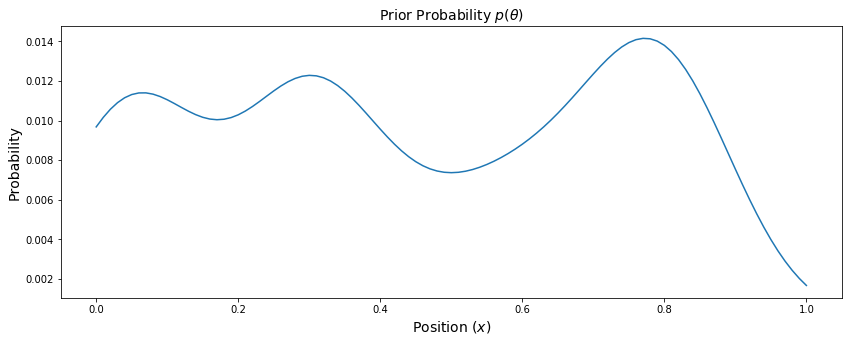

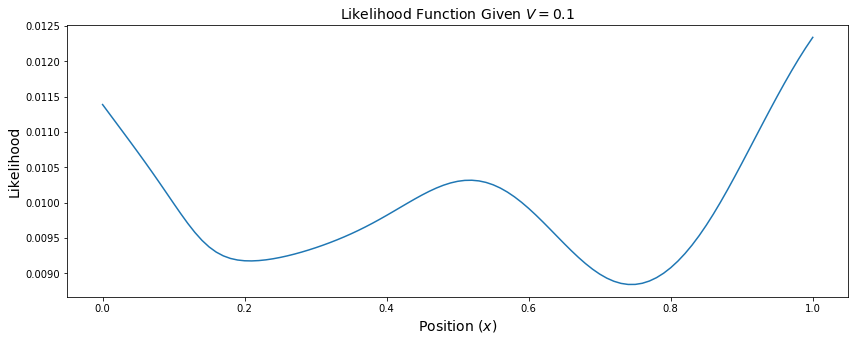

In [10]:
# Construct an arbitrary complex prior belief
priorP = norm.pdf(wsSamples,0.8,0.1) + \
         norm.pdf(wsSamples,0.3,0.1) + \
         norm.pdf(wsSamples,0.05,0.1) + \
         norm.pdf(wsSamples,0.6,0.15) 
priorP /= sum(priorP)
# Plot prior belief
plt.figure(figsize=(14,5))
plot(wsSamples, priorP)
plt.title(r"Prior Probability $p(\theta)$", fontsize=14)
plt.xlabel("Position ($x$)", fontsize=14)
plt.ylabel("Probability", fontsize=14)

# Compute likelihood Pvx
def PvxNew(v, theta=wsSamples, prior=priorP, sigmaM=0.1, sigmaL=0.2):
    pL = Pvtheta(v, theta, sigmaM, sigmaL)
    pvx = pL
    for idx in range(pvx.shape[0]):
        pvx[idx, :] = pvx[idx, :] * prior[idx]
    pvx = pvx.sum(axis=0)
    pvx /= pvx.sum()
    return pvx, pL

# Plot a example given measurement V
plt.figure(figsize=(14,5))
pvx, pl = PvxNew(0.1)
plot(wsSamples, pvx)
plt.title(r'Likelihood Function Given $V=0.1$', fontsize=14)
plt.xlabel('Position ($x$)', fontsize=14);
plt.ylabel('Likelihood', fontsize=14);

Maximum possible entropy = 4.6151205168412615
Entropy of current prior = 4.570760331054973


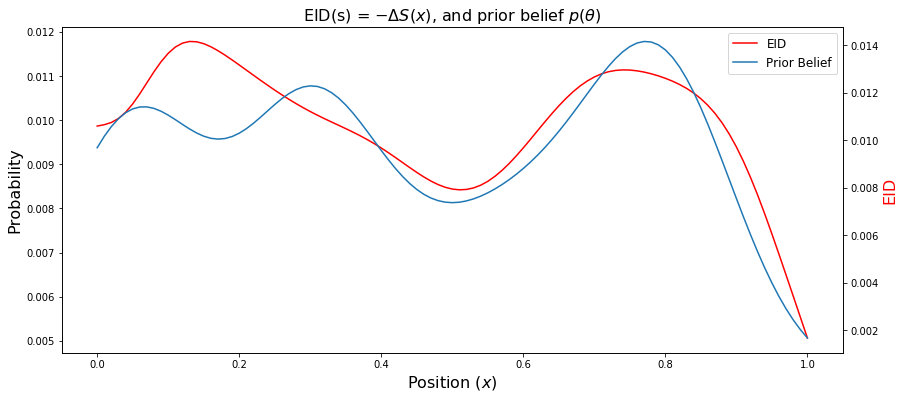

In [7]:
# Construct EER function
def EER(prior, sigmaM=0.1, sigmaL=0.2):
    sBase = entropy(prior)
    deltaS = np.zeros(wsResolution)
    for mms in np.linspace(0,1,wsResolution):
        # Posterior
        pvx, pL = PvxNew(v=mms, prior=prior, sigmaM=sigmaM, sigmaL=sigmaL)
        pp = pL * prior
        # Entropy
        dS = entropy(pp.T) - sBase        
        # Update result
        deltaS += pvx * dS

    # Convert deltaS to Entropy EID
    EER_Entropy = -deltaS
    EER_Entropy[EER_Entropy == np.inf] = 0
    EER_Entropy[EER_Entropy < 0] = 0
    if abs(EER_Entropy).sum() != 0:
        EER_Entropy /= abs(EER_Entropy).sum()
    
    return EER_Entropy

# Compute base entropy
sMax = entropy(np.ones(wsResolution)/wsResolution)
sBase = entropy(priorP)
print("Maximum possible entropy = {0}".format(sMax))
print("Entropy of current prior = {0}".format(sBase))

# Compute EER map
EER_Entropy = EER(priorP)

# Plot entropy map
# plt.figure(figsize=(14,6))
fig, ax1 = plt.subplots(figsize=(14,6))
ax2 = ax1.twinx()
h1 = ax1.plot(wsSamples, EER_Entropy, label='EID', color='r')
h2 = ax2.plot(wsSamples, priorP, label='Prior Belief')
h = h1 + h2
lbl = [l.get_label() for l in h]
plt.title(r"EID(s) = $-\Delta S(x)$, and prior belief $p(\theta)$", fontsize=16)
ax1.set_xlabel("Position ($x$)", fontsize=16)
ax1.set_ylabel("Probability", fontsize=16)
ax2.set_ylabel("EID", fontsize=16, color='r')
plt.legend(h, lbl, fontsize=12);

### Comparison Between Entropy and Fisher Information
In this section, we will compare the use of entropy and Fisher information for computing the expected information density (or EID) for different probability distributions. Fisher information has a number of conveniences for practical application of the ergodic harvesting approach.

In [8]:
from scipy.signal import convolve
def EID(prior, sigmaM=0.1, sigmaL=0.2):
    fi = np.diff(np.insert(Upsilon(0.5, sigmaM),0,0))
    fi = np.abs(fi)
    fi = fi / fi.sum()
    EID_FI = convolve(fi ** 2, prior, mode='same')
    EID_FI = EID_FI / EID_FI.sum()
    return EER(prior, sigmaM, sigmaL), EID_FI

Prior example 1 - flat - entropy = 4.6151205168412615
Prior example 2 - Reciprocal inverse Gaussian, low variance - entropy = 3.4031070758599844
Prior example 3 - Unimodal, centered, high variance - entropy = 4.361006466387932
Prior example 4 - Unimodal, cornered, low variance - entropy = 3.028376445638773
Prior example 5 - Bimodal, centered, high variance - entropy = 4.448656141125786
Prior example 6 - Bimodal, centered, low variance - entropy = 3.902601528409632


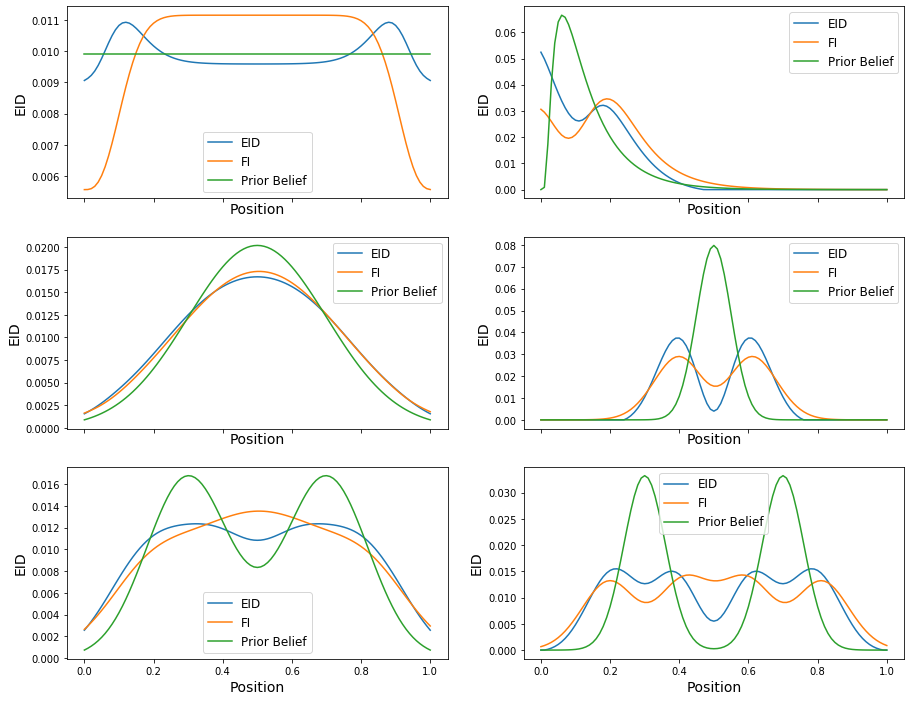

In [9]:
## Construct a variety of different prior beliefs and compute the corresponding EID maps
priorP1 = np.ones(wsResolution)/wsResolution  # Flat belief
EID_Entropy1, EID_FI1 = EID(priorP1)
print("Prior example 1 - flat - entropy = {0}".format(entropy(priorP1)))

priorP2 = recipinvgauss.pdf(wsSamples+1e-4,0.6,0,0.05)  # Reciprocal inverse Gaussian, centered, low variance
priorP2 /= priorP2.sum()
EID_Entropy2, EID_FI2 = EID(priorP2)
print("Prior example 2 - Reciprocal inverse Gaussian, low variance - entropy = {0}".format(entropy(priorP2)))

priorP3 = norm.pdf(wsSamples,0.5,0.2)  # Unimodal, centered, high variance
priorP3 /= priorP3.sum()
EID_Entropy3, EID_FI3 = EID(priorP3)
print("Prior example 3 - Unimodal, centered, high variance - entropy = {0}".format(entropy(priorP3)))

priorP4 = norm.pdf(wsSamples,0.5,0.05)  # Unimodal, centered, low variance
priorP4 /= priorP4.sum()
EID_Entropy4, EID_FI4 = EID(priorP4)
print("Prior example 4 - Unimodal, cornered, low variance - entropy = {0}".format(entropy(priorP4)))

priorP5 = norm.pdf(wsSamples,0.7,0.12) + norm.pdf(wsSamples,0.3,0.12) # Bimodal, centered, high variance
priorP5 /= priorP5.sum()
EID_Entropy5, EID_FI5 = EID(priorP5)
print("Prior example 5 - Bimodal, centered, high variance - entropy = {0}".format(entropy(priorP5)))

priorP6 = norm.pdf(wsSamples,0.7,0.06) + norm.pdf(wsSamples,0.3,0.06) # Bimodal, centered, high variance
priorP6 /= priorP6.sum()
EID_Entropy6, EID_FI6 = EID(priorP6)
print("Prior example 6 - Bimodal, centered, low variance - entropy = {0}".format(entropy(priorP6)))
   
# Build data list
priorList = [priorP1, priorP2, priorP3, priorP4, priorP5, priorP6]
eEIDList = [EID_Entropy1, EID_Entropy2, EID_Entropy3, EID_Entropy4, EID_Entropy5, EID_Entropy6]
fiEIDList = [EID_FI1, EID_FI2, EID_FI3, EID_FI4, EID_FI5, EID_FI6]

## Compare Entropy and Fisher Information on Different Priors
f, axArray = plt.subplots(3, 2, sharex='col', figsize=(15, 12))
axArray = axArray.flatten()
for idx, p in enumerate(priorList):
    axArray[idx].plot(wsSamples, eEIDList[idx], label='EID')
    axArray[idx].plot(wsSamples, fiEIDList[idx], label='FI')
    axArray[idx].plot(wsSamples, p, label='Prior Belief')
    axArray[idx].set_xlabel("Position", fontsize=14)
    axArray[idx].set_ylabel("EID", fontsize=14)
    axArray[idx].legend(fontsize=12, loc='best');